In [50]:
from scipy.spatial import Delaunay, delaunay_plot_2d
from scipy.spatial import KDTree

import numpy as np
import csv
import matplotlib.pyplot as plt

In [13]:
def graph_r(r):

    nodes = []
    edges = []
    edges_distances = []

    with open(f'./data/rosette{r}_nodes.csv', mode='r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        for row in csv_reader:
            if (row!=0):
                values = list(row.values())
                n = []
                n.append(float(values[0]))
                n.extend(22.5-2.5*np.log10([float(n) for n in list(values)[1:]]))
                n.append(float(values[-1]))
                nodes.append(n)

    with open(f'./data/rosette{r}_edges.csv', mode='r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        for row in csv_reader:
            if (row!=0):
                edges_distances.append([float(n) for n in list(row.values())])
                edges.append([float(n) for n in list(row.values())][:2])

    return (nodes,edges,edges_distances)

In [14]:
rosettes = [3,6,7,11,12,13,14,15,18,19]
nodes, edges, distances = graph_r(rosettes[0])

### Voronoi diagram

TypeError: list indices must be integers or slices, not tuple

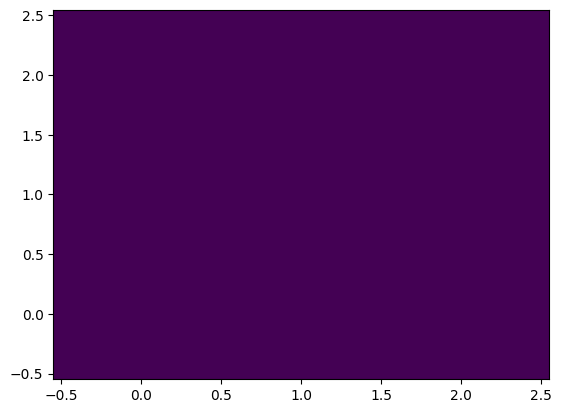

In [20]:
tree = KDTree(edges)

x = np.linspace(-0.5, 2.5, 31)
y = np.linspace(-0.5, 2.5, 33)
xx, yy = np.meshgrid(x, y)
xy = np.c_[xx.ravel(), yy.ravel()]

dx_half, dy_half = np.diff(x[:2])[0] / 2., np.diff(y[:2])[0] / 2.
x_edges = np.concatenate((x - dx_half, [x[-1] + dx_half]))
y_edges = np.concatenate((y - dy_half, [y[-1] + dy_half]))
plt.pcolormesh(x_edges, y_edges, tree.query(xy)[1].reshape(33, 31), shading='flat')
plt.plot(edges[:,0], edges[:,1], 'ko')
plt.show()

### Delaunay triangulations

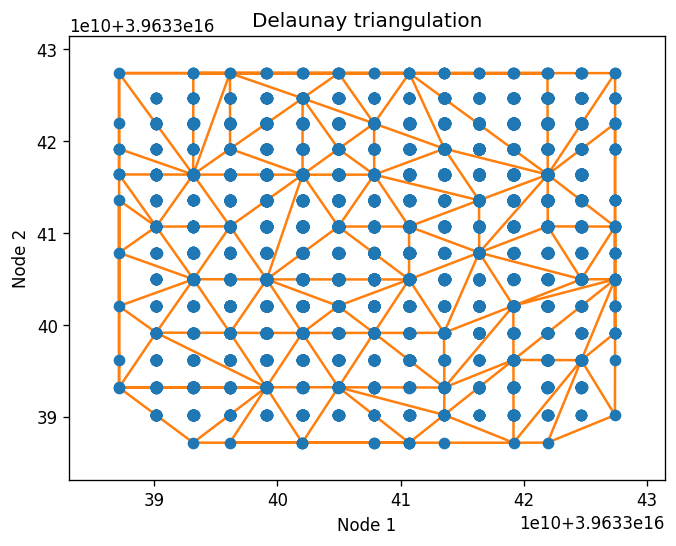

In [53]:
triangulation = Delaunay(edges)
edges = np.array(edges)

plt.rcParams['figure.dpi'] = 120

_ = delaunay_plot_2d(triangulation)
plt.xlabel('Node 1')
plt.ylabel('Node 2')
plt.title('Delaunay triangulation') #! Pero esto son ids, no distancias
plt.show()

In [55]:
from astropy.io import fits
from astropy.cosmology import WMAP9 as cosmo
from astropy.coordinates import SkyCoord
import astropy.units as u
import h5py

In [113]:
hdu = fits.open('./data/BGS_ANY_N_clustering.dat.fits')
data_prova = h5py.File('./data/BGS_ANY_full.provabgs.sv3.v0.hdf5')

In [60]:
hdu = fits.open('./data/BGS_ANY_N_clustering.dat.fits')
data_prova = h5py.File('./data/BGS_ANY_full.provabgs.sv3.v0.hdf5')

data_bgs = hdu[1].data
n_r = np.unique(data_bgs['ROSETTE_NUMBER'])
rosette_n = data_bgs[data_bgs['ROSETTE_NUMBER'] == 15]
ids = rosette_n['TARGETID']

dataset = data_prova['__astropy_table__']
selected = [(row[0], row[15]) for row in dataset if row[0] in ids]

mass = selected
node_info = []
edge_info = []
for j in range(len(mass)):
    data_j = data_bgs[data_bgs['TARGETID'] == mass[j][0]]
    flux_g = data_j['FLUX_G_DERED'][0]
    flux_r = data_j['FLUX_R_DERED'][0]
    flux_z = data_j['FLUX_Z_DERED'][0]
    flux_w1 = data_j['FLUX_W1_DERED'][0]
    flux_w2 = data_j['FLUX_W2_DERED'][0]
    z =  data_j['Z']
    if mass[j][1]>0:
        node_info.append([mass[j][0], mass[j][1], flux_g, flux_r, flux_z, flux_w1, flux_w2, z])
        RA = data_j['RA'][0]
        DEC = data_j['DEC'][0]
        d_n = cosmo.comoving_distance(data_j['Z'])
        edge_info.append([mass[j][0], RA, DEC, d_n.value[0]])
nodes = node_info #! Hasta aqui bien

edge_info = np.array(edge_info)
coords = SkyCoord(ra=edge_info[:, 1] * u.deg, dec=edge_info[:, 2] * u.deg, distance=edge_info[:, 3] * u.Mpc) #* paso a coordenadas celestes
angular_distances = coords[:, np.newaxis].separation(coords)
r = np.sqrt(edge_info[:, 3]**2 + edge_info[:, 3]**2 - 2 * edge_info[:, 3] * edge_info[:, 3][:, np.newaxis] * np.cos(angular_distances.rad))
mask = (r < 10.0) & (r > 0)
indices_i, indices_j = np.where(mask)
edges = [(edge_info[i][0], edge_info[j][0], r[i, j]) for i, j in zip(indices_i, indices_j)]

/var/folders/ls/yc9nb2gx14s6sstnjr_fcy5r0000gn/T/ipykernel_12759/3088926574.py:34: RuntimeWarning: invalid value encountered in sqrt
  r = np.sqrt(edge_info[:, 3]**2 + edge_info[:, 3]**2 - 2 * edge_info[:, 3] * edge_info[:, 3][:, np.newaxis] * np.cos(angular_distances.rad))


In [98]:
edge_info = np.array(edge_info)
coords = SkyCoord(ra=edge_info[:, 1] * u.deg, dec=edge_info[:, 2] * u.deg, distance=edge_info[:, 3] * u.Mpc) #* paso a coordenadas celestes
angular_distances = coords[:, np.newaxis].separation(coords)
angular_distances

<Angle [[0.        , 0.04236525, 1.5390961 , ..., 2.60626668, 3.32345013,
         2.84478866],
        [0.04236525, 0.        , 1.50637147, ..., 2.63879103, 3.34015733,
         2.8740295 ],
        [1.5390961 , 1.50637147, 0.        , ..., 3.26815502, 3.25367555,
         3.33675452],
        ...,
        [2.60626668, 2.63879103, 3.26815502, ..., 0.        , 1.54774303,
         0.39053284],
        [3.32345013, 3.34015733, 3.25367555, ..., 1.54774303, 0.        ,
         1.19139657],
        [2.84478866, 2.8740295 , 3.33675452, ..., 0.39053284, 1.19139657,
         0.        ]] deg>

In [103]:
r = np.sqrt(edge_info[:, 3]**2 + edge_info[:, 3]**2 - 2 * edge_info[:, 3] * edge_info[:, 3][:, np.newaxis] * np.cos(angular_distances.rad))

/var/folders/ls/yc9nb2gx14s6sstnjr_fcy5r0000gn/T/ipykernel_12759/2242556913.py:1: RuntimeWarning: invalid value encountered in sqrt
  r = np.sqrt(edge_info[:, 3]**2 + edge_info[:, 3]**2 - 2 * edge_info[:, 3] * edge_info[:, 3][:, np.newaxis] * np.cos(angular_distances.rad))


In [114]:
mask = (r < 10.0) & (r > 0)
indices_i, indices_j = np.where(mask)
edges = [(angular_distances[i], angular_distances[j]) for i, j in zip(indices_i, indices_j)]

In [115]:
edges[0]

(<Angle [1.5390961 , 1.50637147, 0.        , ..., 3.26815502, 3.25367555,
         3.33675452] deg>,
 <Angle [2.82612569, 2.83036549, 2.35362046, ..., 2.06787337, 1.05985916,
         1.84671276] deg>)